## Importing the general libraries

In [1]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

## Importing the dataset

In [2]:
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_labels_val.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/yqb3e/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

In [3]:
with np.load(fname) as dobj:
    dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')


`labels` is a 4 by stim array of class names:  
- row 3 has the labels predicted by a deep neural network (DNN) trained on Imagenet
- rows 0-2 correspond to different levels of the wordnet hierarchy for the DNN predictions

In [4]:
print(labels[:,:4])

[['artifact' 'entity' 'animal' 'animal']
 ['instrumentality' 'round shape' 'vertebrate' 'vertebrate']
 ['equipment' 'sphere' 'mammal' 'amphibian']
 ['croquet ball' 'bubble' 'komondor' 'tailed frog']]


In [5]:
np.unique(labels[0])

array(['animal', 'artifact', 'entity', 'fruit', 'fungus',
       'geological formation', 'person', 'plant'], dtype='<U71')

In [6]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


`dat` has the following fields:  
- `stimuli`: stim x i x j array of grayscale stimulus images
- `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set  
- `responses`: stim x voxel array of z-scored BOLD response amplitude
- `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

## Preprocessing the I/P Dataset

In [7]:
labels = np.hstack((labels, val_labels))
labels.shape

(4, 1870)

In [8]:
for cat in np.unique(labels[0]):
  print(cat, (labels.T == cat).sum())

animal 643
artifact 862
entity 76
fruit 78
fungus 6
geological formation 202
person 2
plant 1


In [9]:
living_mask = np.logical_or(labels.T[:, 0]== 'animal', np.logical_or(labels.T[:, 0] == 'fruit', np.logical_or(labels.T[:, 0] == 'fungus', np.logical_or(labels.T[:, 0]=='person', np.logical_or(labels.T[:, 0]=='plant', np.logical_and(labels.T[:, 0]=='entity', labels.T[:, 2]=='food'))))))#, labels.T[: 0] == 'fungus')#, labels.T[:, 0] == 'person', labels.T[:, 0] == 'plant', labels.T[:, 2] == 'food') 
non_living_mask = labels.T[:, 0]=='artifact'
to_remove = 60
living_mask.sum(), non_living_mask.sum()
for i in range(non_living_mask.size):
  if non_living_mask[i] == 1:
    non_living_mask[i] = 0
    to_remove = to_remove - 1
    if to_remove == 0:
      break
living_mask.sum(), non_living_mask.sum()
# X =X[lving_mask]
# y = u[living_mask]

(802, 802)

In [10]:
dat['responses'].shape

(1750, 8428)

In [11]:
dat['responses'] = np.vstack((dat['responses'], dat['responses_test']))
dat['responses'][non_living_mask].shape

(802, 8428)

##Splitting the voxels according to RoI

In [12]:
X0 = dat['responses'][non_living_mask|living_mask] #independent variable
y0 = labels.T[:,0][non_living_mask | living_mask] #dependent variable
#y0 = labels[0,:]
print(y0.shape)

(1604,)


In [ ]:
'''X0 = dat['responses'] #independent variable
y0 = labels.T[:,0] #dependent variable
#y0 = labels[0,:]
print(y0.shape)'''

"X0 = dat['responses'] #independent variable\ny0 = labels.T[:,0] #dependent variable\n#y0 = labels[0,:]\nprint(y0.shape)"

In [13]:
X0.shape, y0.shape

((1604, 8428), (1604,))

In [ ]:
'''from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y0 = le.fit_transform(y0)
print(y0)'''

'from sklearn.preprocessing import LabelEncoder\nle = LabelEncoder()\ny0 = le.fit_transform(y0)\nprint(y0)'

## Feature Scaling

In [14]:
from sklearn.preprocessing import StandardScaler
def feature_scaling(X_train, X_test):
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)
  return (X_train, X_test)

## Splitting the dataset into training and test set


In [15]:
from sklearn.model_selection import train_test_split
def train_test_data(X1,y1):
  X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.25, random_state = 0)
  X_train, X_test = feature_scaling(X_train, X_test)
  #print(len(y_train))
  #print(len(X_test))
  return X_train, X_test, y_train, y_test

## Training using Logistic Regression model and Predicting

In [16]:
from sklearn.linear_model import LogisticRegression
def logistic_regression(X_train,y_train):
  #classifier = LogisticRegression(random_state = 0, max_iter=2000)
  classifier = LogisticRegression(C=0.028571428571428574, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=1000, multi_class='auto', n_jobs=None, penalty='l1',
                    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False)
#   '''LogisticRegression(C=0.04571428571428572, class_weight=None, dual=False,
#                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
#                    max_iter=1000, multi_class='auto', n_jobs=None, penalty='l1',
#                    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
#                    warm_start=False)'''
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  return y_pred, classifier

## Training using KNN Classifier and Predicting

In [17]:
from sklearn.neighbors import KNeighborsClassifier
def KNNClassifier(X_train,y_train):
  classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  return y_pred

In [18]:
from sklearn.tree import DecisionTreeClassifier
def DecisionTree(X_train,y_train):
  classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  return y_pred

In [19]:
from sklearn.naive_bayes import GaussianNB
def NaiveBayes(X_train,y_train):
  classifier = GaussianNB()
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  return y_pred

In [20]:
from sklearn.svm import SVC
def KernelSVM(X_train,y_train):
  classifier = SVC(C=0.0001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
                  decision_function_shape='ovr', degree=3, gamma=100, kernel='linear',
                  max_iter=-1, probability=False, random_state=None, shrinking=True,
                  tol=0.001, verbose=False)
  #classifier = SVC(kernel = 'rbf', random_state = 0) 
  #classifier = SVC(kernel = 'linear', random_state = 0)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  return y_pred

In [21]:
from sklearn.ensemble import RandomForestClassifier
def RandomForest(X_train,y_train):
  #classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0) #gini
  classifier = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=100, max_features=2,
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=4, min_samples_split=10,
                        min_weight_fraction_leaf=0.0, n_estimators=1000,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  return y_pred

##Making the Confusion Matrix and Accuracy Score

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
def accuracy_score_LR(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  #print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
  #print(cm)
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

In [23]:
#Testing Category classes and the number of images in it
for category in np.unique(labels[0]):
  y1 = (labels.T[:, 0]==category)
  print(np.sum(y1), category)

643 animal
862 artifact
76 entity
78 fruit
6 fungus
202 geological formation
2 person
1 plant


In [24]:
X0.shape, y0.shape

((1604, 8428), (1604,))

In [ ]:
'''y0 = labels.T[non_living_mask | living_mask]
y_living = y0[y0[:, 0] == 'artifact']
y_non_living = y0[y0[:, 0] != 'artifact']
y_living.shape, y_non_living.shape'''

"y0 = labels.T[non_living_mask | living_mask]\ny_living = y0[y0[:, 0] == 'artifact']\ny_non_living = y0[y0[:, 0] != 'artifact']\ny_living.shape, y_non_living.shape"

## Contrast Comparison

In [25]:
dat['stimuli'] = np.vstack((dat['stimuli'], dat['stimuli_test']))
dat['stimuli'].shape

(1870, 128, 128)

In [26]:
def shift_and_scale(im):
  return np.floor(128*(im - dat['stimuli'].min()))
def contrast1(im):
  mean = np.mean(im)
  return np.sum(((im-mean)/mean)**2)/(im.shape[0] * im.shape[1])

def contrast2(im):
  mean = np.mean(im)
  return np.sum(((im-mean)/mean)**2)/(im.size)

def contrast3(im):
  mean = np.mean(im)
  return (np.max(im) - np.min(im))/(np.max(im) + np.min(im))


In [ ]:
m1 = dat['stimuli'].shape[0]
res = np.zeros(m1)
for k in range(m1):
  img = dat['stimuli'][k]
  r = 60
  res1 = []
  m, n = img.shape
  for i in range(m):
    for j in range(n):
      x = j-60
      y = 60-i
      if (x*x + y*y)**.5 <= r:
        res1.append(img[i][j])
  res[k] = contrast2(shift_and_scale(np.array(res1)))
  print(contrast2(shift_and_scale(np.array(res1))), res[k])
  #print(len(res1))

0.30076351633780674 0.30076351633780674
5.528248253277527 5.528248253277527
0.6666413205055807 0.6666413205055807
0.2571340360361857 0.2571340360361857
0.21144117925912392 0.21144117925912392
0.33018755467158295 0.33018755467158295
0.158987147506699 0.158987147506699
0.1715381252975795 0.1715381252975795
0.10423963419866684 0.10423963419866684
0.20002074405948267 0.20002074405948267
0.16171787196745727 0.16171787196745727
0.09337021848563867 0.09337021848563867
0.5087202472401231 0.5087202472401231
0.36584082299417575 0.36584082299417575
0.39858979323068916 0.39858979323068916
0.15801525631283772 0.15801525631283772
0.19124591174207192 0.19124591174207192
0.6937326469627514 0.6937326469627514
0.05839867430926953 0.05839867430926953
0.5197587599100895 0.5197587599100895
0.24215592543072903 0.24215592543072903
0.4521143542663212 0.4521143542663212
0.4087936126982018 0.4087936126982018
0.39155623352932056 0.39155623352932056
0.30398399264494197 0.30398399264494197
0.1902934194445367 0.190

In [ ]:
np.percentile(res,50)

0.2448422400435435

(array([ 57., 231., 268., 290., 253., 183., 135.,  95.,  67.,  47.,  40.,
         40.,  31.,  22.,  15.,  15.,  16.,  12.,   7.,   5.,   3.,   3.,
          4.,   4.,   3.,   2.,   3.,   2.,   2.,   2.,   0.,   0.,   0.,
          1.,   0.,   1.,   2.,   3.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.00785749, 0.0630614 , 0.1182653 , 0.17346921, 0.22867312,
        0.28387703, 0.33908093, 0.39428484, 0.44948875, 0.50469266,
        0.55989656, 0.61510047, 0.67030438, 0.72550829, 0.78071219,
        0.8359161 , 0.89112001, 0.94632392, 1.00152783, 1.05673173,
        1.11193564, 1.16713955, 1.22234346, 1.

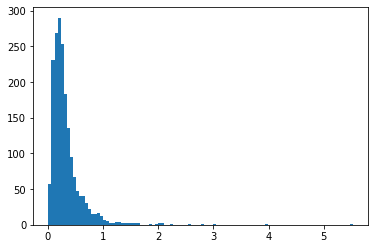

In [ ]:
plt.hist(res,bins=100)

In [ ]:
np.sum(res>np.percentile(res,50))

935

In [ ]:
# n = dat['stimuli'].shape[0]

# means = np.zeros(n)
# contrasts = np.zeros(n)
# for i in range(n):
#   im2 = shift_and_scale(dat['stimuli'][i])
#   means[i] = im2.mean()
#   contrasts[i] = contrast1(im2)
  
# contrasts.shape, means.mean(), contrasts.mean(), np.median(contrasts), (contrasts>0.2).sum()

## Edge Detection

In [27]:
from scipy import ndimage
from scipy.ndimage.filters import convolve

from scipy import misc
import numpy as np

class cannyEdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return 
    
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g
    
    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.filters.convolve(img, Kx)
        Iy = ndimage.filters.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)
    

    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img
    
    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):    
            self.img_smoothed = convolve(img, self.gaussian_kernel(self.kernel_size, self.sigma))
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)
            #print(i)
        return self.imgs_final

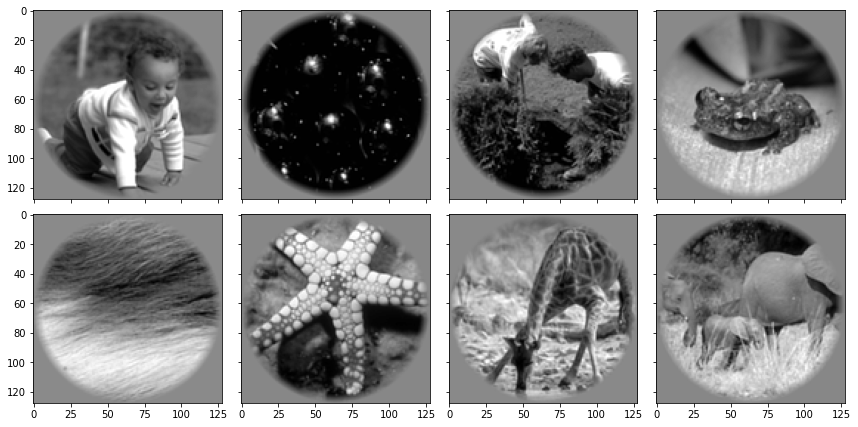

In [28]:
f, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im in zip(axs.flat, dat['stimuli']):
  ax.imshow(im, cmap="gray")
f.tight_layout()

In [29]:
# cnd = cannyEdgeDetector(images1[0:12])
cnd = cannyEdgeDetector(dat['stimuli'])
images = cnd.detect()
# f, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
# for ax, im in zip(axs.flat, images):
#   ax.imshow(im, cmap="gray")
# f.tight_layout()

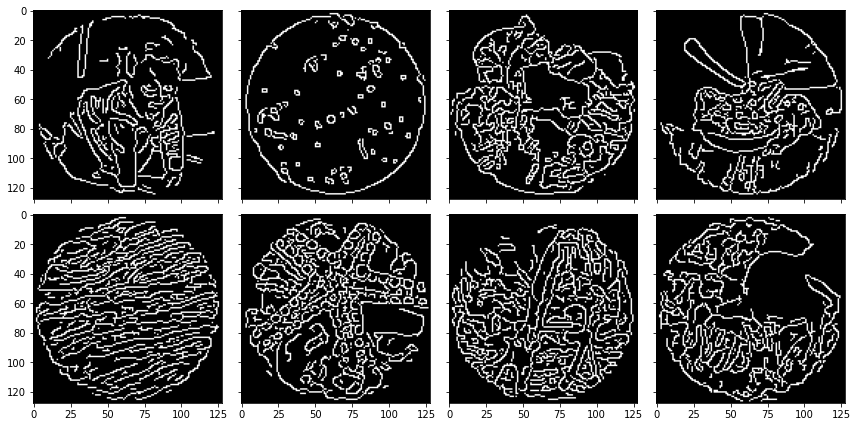

In [40]:
f, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im in zip(axs.flat, images):
  ax.imshow(im, cmap="gray")
f.tight_layout()

In [30]:
m2 = dat['stimuli'].shape[0]
edges = np.zeros(m2)
for i in range(m2):
  edges[i] = np.sum(images[i]==255)/(120*120)

(array([ 1.,  1.,  0.,  2.,  1.,  0.,  4.,  3.,  0.,  3.,  6.,  3., 10.,
         1.,  8., 14., 12., 18., 17., 14., 20., 17., 15., 26., 17., 26.,
        32., 34., 31., 38., 30., 41., 40., 35., 26., 45., 38., 44., 44.,
        47., 60., 53., 36., 51., 47., 29., 40., 44., 45., 42., 46., 32.,
        41., 44., 39., 35., 23., 29., 28., 24., 17., 17., 20., 18., 13.,
        27., 21., 19., 14., 11., 23., 11., 11., 10.,  6.,  8.,  8.,  6.,
         8.,  6.,  9.,  5.,  3.,  2.,  3.,  5.,  1.,  1.,  7.,  1.,  2.,
         2.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([0.03118056, 0.03401319, 0.03684583, 0.03967847, 0.04251111,
        0.04534375, 0.04817639, 0.05100903, 0.05384167, 0.05667431,
        0.05950694, 0.06233958, 0.06517222, 0.06800486, 0.0708375 ,
        0.07367014, 0.07650278, 0.07933542, 0.08216806, 0.08500069,
        0.08783333, 0.09066597, 0.09349861, 0.09633125, 0.09916389,
        0.10199653, 0.10482917, 0.10766181, 0.11049444, 0.11332708,
        0.11615972, 0.1189

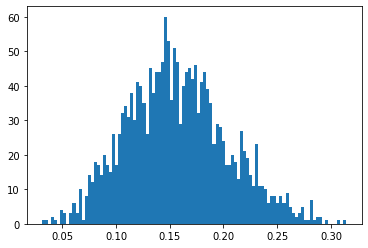

In [31]:
plt.hist(edges, bins=100)

In [32]:
np.percentile(edges,50)

0.15447916666666667

In [33]:
np.sum(edges>np.percentile(edges,50))

935

## Main Code for execution

In [34]:
test_accuracies = np.zeros((7, 8))

In [35]:
X0 = dat['responses']
#X0 = dat['responses'][non_living_mask|living_mask] 
for roi in range(1, 2):
  X1 = X0#[:, dat['roi'] == roi] #!=roi]
  #y1 = res>np.percentile(res,50)
  y1 = edges>np.percentile(edges,50)
  #y1 = y0 == 'artifact'

  #Splitting the dataset into train and test set & Feature Scaling
  X_train, X_test, y_train, y_test = train_test_data(X1,y1)

  # Training the dataset and predicting the test set
  print(X1.shape, y1.shape, y_test.shape, y_train.shape, X_test.shape, X_train.shape)
  y_pred1, classifier = logistic_regression(X_train,y_train)
  #y_pred = RandomForest(X_train,y_train)

  #Computaing accuracy of test dataset    
  test_accuracy = accuracy_score_LR(y_test, y_pred1)
  test_accuracies[roi-1][2] = test_accuracy

  y_pred2 = KernelSVM(X_train,y_train) 
  test_accuracy = accuracy_score_LR(y_test, y_pred2)
  test_accuracies[roi-1][3] = test_accuracy

(1870, 8428) (1870,) (468,) (1402,) (468, 8428) (1402, 8428)


In [ ]:
print(test_accuracy)

0.7222222222222222


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.2687105 , -0.22376408, -0.17881766, -0.13387123, -0.08892481,
        -0.04397839,  0.00096803,  0.04591446,  0.09086088,  0.1358073 ,
         0.18075372]),
 <a list of 8428 Lists of Patches objects>)

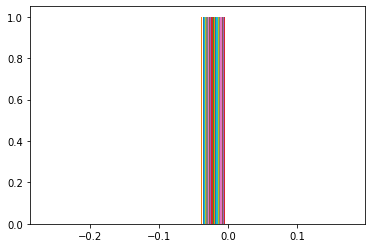

In [ ]:
plt.hist(classifier.coef_)

In [37]:
aa = classifier.coef_
print(aa, aa.min(), np.percentile(aa,25), np.percentile(aa,50), np.percentile(aa,75), aa.max(), np.sum(aa==0), aa.shape)

[[0. 0. 0. ... 0. 0. 0.]] -0.26873045116294325 0.0 0.0 0.0 0.1814609033375909 8284 (1, 8428)


In [39]:
for roi in range(1,8):
  bb = aa[:,dat['roi'] == roi]
  print(roi, np.sum(bb!=0)*100/bb.shape[1], bb.shape[1], np.sum(bb!=0))

1 1.3910355486862442 1294 18
2 2.4483917426788286 2083 51
3 1.1731843575418994 1790 21
4 3.0991735537190084 484 15
5 1.2738853503184713 314 4
6 1.498371335504886 1535 23
7 1.293103448275862 928 12


In [ ]:
from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=classifier, X=X1, y=y1, cv=10)

In [ ]:
aa = all_accuracies
print(aa.min(), np.percentile(aa,25), np.percentile(aa,50), np.percentile(aa,75), aa.max(), np.sum(aa==0), aa.shape)

0.7112299465240641 0.7219251336898396 0.7299465240641712 0.7486631016042781 0.7754010695187166 0 (10,)


In [ ]:
print(test_accuracies)

[[0.         0.         0.         0.         0.         0.
  0.65598291 0.63888889]
 [0.         0.         0.         0.         0.         0.
  0.66880342 0.63247863]
 [0.         0.         0.         0.         0.         0.
  0.61752137 0.59615385]
 [0.         0.         0.         0.         0.         0.
  0.55982906 0.49145299]
 [0.         0.         0.         0.         0.         0.
  0.56196581 0.49145299]
 [0.         0.         0.         0.         0.         0.
  0.63247863 0.59615385]
 [0.         0.         0.         0.         0.         0.
  0.5491453  0.54273504]]


In [ ]:
'''test_accuracies = np.zeros((7, 2))
for roi in range(1, 8):
  X1 = X0[:, dat['roi'] == roi] #!=roi]
  #y = labels.T[:,0]
  y1 = y0 != 'artifact'

  #Splitting the dataset into train and test set & Feature Scaling
  X_train, X_test, y_train, y_test = train_test_data(X1,y1)

  # Training the dataset and predicting the test set
  print(X1.shape, y1.shape, y_test.shape, y_train.shape, X_test.shape, X_train.shape)
  y_pred = logistic_regression(X_train,y_train)

  #Computaing accuracy of test dataset    
  test_accuracy = accuracy_score_LR(y_test, y_pred)
  test_accuracies[roi-1][0] = test_accuracy'''

## GridSearchCV

In [ ]:
X1 = X0
y1 = y0 == 'artifact'

#Splitting the dataset into train and test set & Feature Scaling
X_train, X_test, y_train, y_test = train_test_data(X1,y1)

In [ ]:
#Logistic Regression
from sklearn.model_selection import GridSearchCV 
  
# Creating the hyperparameter grid 
c_space = np.linspace(0.01, 0.08, 50)
#c_space = np.logspace(-5, 0, 20) 
param_grid = {'C': c_space, 'penalty':['l1','l2']} 
  
# Instantiating the GridSearchCV object 
grid = GridSearchCV(LogisticRegression(max_iter = 1000, solver = 'liblinear'), param_grid, cv = 10) 
  
grid.fit(X_train, y_train) 
  
# Print the tuned parameters and score 
print("Tuned Logistic Regression Parameters: {}".format(grid.best_params_))  
print("Best score is {}".format(grid.best_score_))

For One But All Region
Tuned Logistic Regression Parameters: {'C': 0.03142857142857143, 'penalty': 'l1'}
Best score is 0.6982369146005509

For One Region 
Tuned Logistic Regression Parameters: {'C': 0.044285714285714296, 'penalty': 'l1'}
Best score is 0.6883195592286501


In [ ]:
grid.best_estimator_, grid.best_params_, grid.best_score_

In [ ]:
#RandomForest
param_grid = {
    'bootstrap': [True],
    'max_depth': [80],#, 90, 100, 110],
    'max_features': [4, 5, 6],
    'min_samples_leaf': [3],
    'min_samples_split': [6, 7, 8],
    'n_estimators': [385, 390, 395],
    'criterion' : ['entropy']
}

gridRF = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
gridRF.fit(X_train, y_train) 

# Print the tuned parameters and score 
print("Tuned RandomForestClassifier Parameters: {}".format(gridRF.best_params_))  
print("Best score is {}".format(gridRF.best_score_))

Tuned RandomForestClassifier Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 300}
Best score is 0.6467165419783875



In [ ]:
gridRF.best_estimator_, gridRF.best_params_, gridRF.best_score_

##RandomSearchCv

In [ ]:
from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint 
  
# Creating the hyperparameter grid  
param_dist = {'C': [0.1, 0.2, 0.3, 0.4, 0.5]} 
  
# Instantiating RandomizedSearchCV object 
grid = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_dist, cv = 5) 
  
grid.fit(X_train, y_train) 
  
# Print the tuned parameters and score 
print("Tuned Logistic Regression Parameters: {}".format(grid.best_params_)) 
print("Best score is {}".format(grid.best_score_))

In [ ]:
grid.best_estimator_, grid.best_params_, grid.best_score_

##Accuracy

In [ ]:
'''test_accuracies = np.zeros((7, 5))
for roi in range(1, 8):
  X = X0[:, dat['roi'] == roi] #!=roi]
  y = labels.T[:,0]
  j=0
  for category in ['animal', 'artifact', 'entity', 'fruit','geological formation']:
    X1 = X.copy()  #(1750 * ..)
    y1 = (labels.T[:, 0]==category).copy()   #(1750,)

    #Splitting the dataset into train and test set & Feature Scaling
    X_train, X_test, y_train, y_test = train_test_data(X1,y1)

    # Training the dataset and predicting the test set
    print(X1.shape, y1.shape, y_test.shape, y_train.shape, X_test.shape, X_train.shape)
    y_pred = logistic_regression(X_train,y_train)

    #Computaing accuracy of test dataset    
    test_accuracy = accuracy_score_LR(y_test, y_pred)
    test_accuracies[roi-1][j] = test_accuracy
    j=j+1'''

In [ ]:
print(test_accuracies)

In [ ]:
dict(zip(dat["roi_names"], np.bincount(dat["roi"])))

## Visualising the training set results

In [ ]:
dat["responses"][n,dat['roi'] == 1].shape

In [ ]:
plt.plot(np.sort(dat["roi"]),'.')

## Visualising the test set results

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

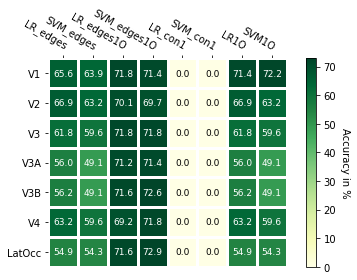

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

im, cbar = heatmap(test_accuracies*100, ['V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'LatOcc'], ['LR_edges', 'SVM_edges', 'LR_edges1O', 'SVM_edges1O','LR_con1', 'SVM_con1',
                                                                                       'LR1O', 'SVM1O'], ax=ax,
                   cmap="YlGn", cbarlabel="Accuracy in %")
texts = annotate_heatmap(im, valfmt="{x:.1f}", size=9)

fig.tight_layout()
plt.show()

## Visualising the Input data

Each stimulus is a 128 x 128 grayscale array:

In [ ]:
dat["stimuli"][labels.T[:,0]=='entity'].shape

In [ ]:
f, axs = plt.subplots(7, 7, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli"][labels.T[:,0]=='artifact'], labels[-1,:][labels.T[:,0]=='artifact']):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
f.tight_layout()

Each stimulus is associated with a pattern of BOLD response across voxels in visual cortex:

In [ ]:
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"], aspect="auto", vmin=-1, vmax=1, cmap="bwr")
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

The training/validation splits from the original paper are retained, so the 120 test stimuli and responses are in separate data structures:

In [ ]:
f, axs = plt.subplots(3, 3, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli_test"], labels[-1,:]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
f.tight_layout()

In [ ]:
f, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"], aspect="auto", vmin=-1, vmax=1, cmap="bwr")
f.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
f.tight_layout()